# D2: Final Dataset - Data Collection, Analysis, Wrangling, Feature Engineering

Id | Category     | Value | Description 
--|:---------:|:-----------:|:-----------:
1|Name      | <i><b>Eric Gao | I'm working alone
2|Andrew ID   | <i><b>jingxia3 | My Andrew ID
3|Project Name | <i><b>Feeling Artsy | Extracting human emotions with CV techniques

## D2.1: Data Collection

**Important note: my Windows Defender reported some trojan horses in the images I downloaded. I have no idea whether they are actually trojan horses or are misclassified because of the raw binary image files before I converted them to image format. I do not guarantee the dataset is completely safe.**

**Disclaimer: The crawler is written purely for academic purposes. I do not take any responsibilities for any illegal use of the code.**

$\to$ For the data collection, I wrote following scripts:

* `image_downloader.py` - this contains the main function calls to crawl Google Images and download images to a folder using search words. All of the images are automatically reshaped to (100,100). <br>
    
* `crawler.py` - this library provide functions to emulate searching on Google Images by specific search word and gathering image urls. It uses the `selenium` library as well as `chromedriver.exe` to directly use chrome browser API to access webpages (to avoid crawler detection and make the crawling faster).<br>
    
* `downloader.py` - this library provide functions to save images using image urls. It uses the `concurrent.futures` library to perform multi-thread image downloading.<br>
    
* `postprocessing.py` - this is for combining images from different folders (with labels indicated by the folder name) into one folder, then store the file names and picture labels in a .csv file.<br>

$\to$ Here are the steps to follow if you want to run the data collection process yourself:

1. Put the aformentioned python scripts under one folder. <br>
    
1. Look for your version of `chromedriver` on `https://chromedriver.chromium.org/downloads`. After you download it (no need to install), change the `chrome_path` variable in `crawler.py` to path to your `chromedriver` if needed. <br>

1. Run the `image_downloader.py`. In the file you can have a list of keywords (stored in the variable `keywords`). For this project, `happiness`, `love`, `excitement` represent positive emotions and `sadness`, `fear`, `loneliness` represent negative emotions. The program will start running and will download at most 1500 images for each keyword. Change the `max_number` parameter in `crawl_image_urls` function in `crawler.py` if needed. <br>

1. After the previous two steps, you should have some folders of images. Rename folders if you'd like to. I renamed folders to `0` and `1` for simplicity of labelling. <br>

1. Change around parameters in the `postprocessing.py` if needed and run it. The script should generate a folder named `images` with all images in it, and an `output.csv` file that corresponds to image file names and their labels would be generated. Note that the files are first remained to `[folder name of image]img_xxx.suffix`, so conveniently the folder-names-as-labels strategy works. <br>

$\to$ Here are some additional notes:
* See the folder `crawler` for code. All of my code are explained using comments.
* See the folder `images` for dataset. The first letter in file name is the label.

## D2.2: Data Analysis

* First I need to import some basic libraries and define function for loading image

In [1]:
#import all basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.dpi']= 90

In [2]:
# define function for loading images
import os
import skimage
from skimage import io
from tqdm import tqdm
import imageio
from PIL import Image

def load_images(path='./images'):
    ids = os.listdir(path)
    images = {}
    for fname in tqdm(ids):
        product_id = fname
        img = Image.open("{}/{}".format(path, fname))
        img = np.uint8(np.asarray(img))
        if img.shape == (100,100,3):
            images[product_id] = img
    print("Loaded {} images".format(len(images)))
    return images

* After the cell below, images are stored in a dictionary: ${\{image name:pixel array\}}$

In [3]:
images = load_images() # load images

100%|██████████| 888/888 [00:00<00:00, 3303.97it/s]

Loaded 816 images


In [4]:
images['0img_0001.jpeg'].shape # 100x100 pixels, 3 colors

(100, 100, 3)

* I store images in one dataframe and read from the csv which contains image names and their labels

In [5]:
imagedf = pd.DataFrame(images.items(), columns=['id','image'])
datadf = pd.read_csv("output.csv")

In [6]:
datadf.columns

Index(['ID', 'Label'], dtype='object')

* I combined these dataframes

In [7]:
df = pd.DataFrame(columns=['ID','image','label'])
ind = 0
for ID in images:
    df.loc[ind] = [ID, images[ID], datadf[datadf['ID']==ID]['Label'].iloc[0]]
    ind += 1

In [8]:
df.shape,df.columns

((816, 3), Index(['ID', 'image', 'label'], dtype='object'))

* I separated the 3d pixel array to 3 columns

In [9]:
def get_red(row):
    return row['image'][:,:,0]
def get_green(row):
    return row['image'][:,:,1]
def get_blue(row):
    return row['image'][:,:,2]

df['red'] = df.apply(get_red, axis=1)
df['green'] = df.apply(get_green, axis=1)
df['blue'] = df.apply(get_blue, axis=1)

In [10]:
df['red'].shape,df['red'][4].shape

((816,), (100, 100))

Below I look for samples from each class to do some EDA.
Note that:
* label 0: paintings that show positive feelings
* label 1: paintings that show negative feelings

In [11]:
# finding some samples of each class
samples = []

curtar = 0 # we're finding this example now
for index, row in df.iterrows():
    if row['label'] == curtar:
        samples.append(row)
        curtar += 1
    if curtar > 3: # when we found all classes
        break

In [12]:
samples[0]

ID                                          0img_0001.jpeg
image    [[[251, 251, 253], [251, 251, 253], [251, 251,...
label                                                    0
red      [[251, 251, 251, 251, 251, 251, 251, 251, 251,...
green    [[251, 251, 251, 251, 251, 251, 251, 251, 251,...
blue     [[253, 253, 253, 253, 253, 253, 253, 253, 253,...
Name: 0, dtype: object

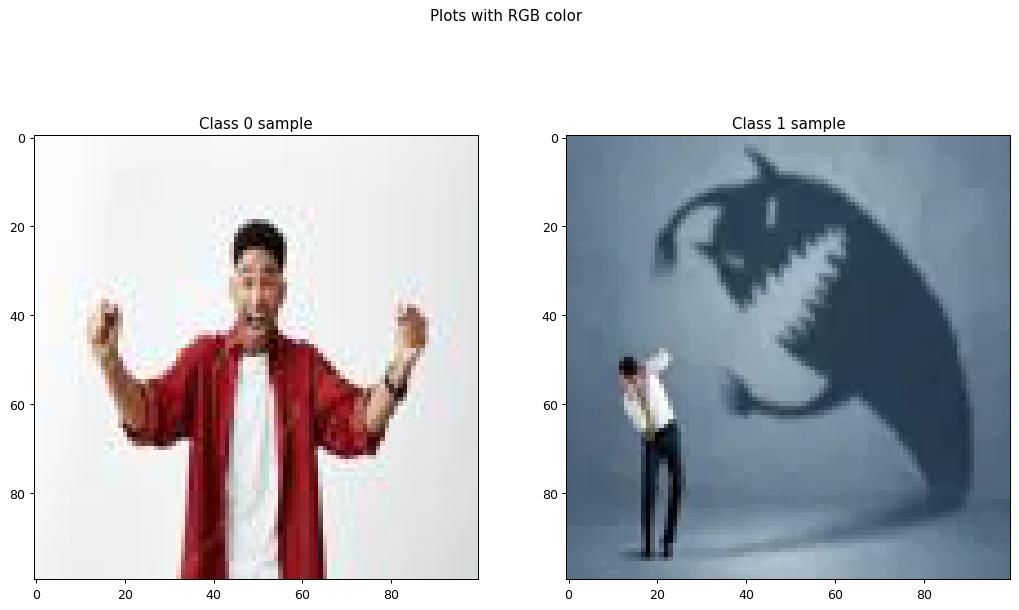

In [13]:
# RGB plots
figure, subplots = plt.subplots(1, 2, figsize=(14, 8))
figure.suptitle("Plots with RGB color")

x = 0
for sample in samples:
    subplots[x].imshow(np.array(sample['image']).reshape(100,100,3))
    subplots[x].title.set_text(f"Class {sample['label']} sample")
    x += 1

plt.show()

Class 0 sample
Red	Mean:213.76	Median:237.0	Variance:2524.82
Green	Mean:197.99	Median:237.0	Variance:6336.06
Blue	Mean:198.67	Median:238.0	Variance:6415.81
Class 1 sample
Red	Mean:97.7	Median:104.0	Variance:1404.76
Green	Mean:118.69	Median:125.0	Variance:1435.25
Blue	Mean:136.38	Median:144.0	Variance:1381.31


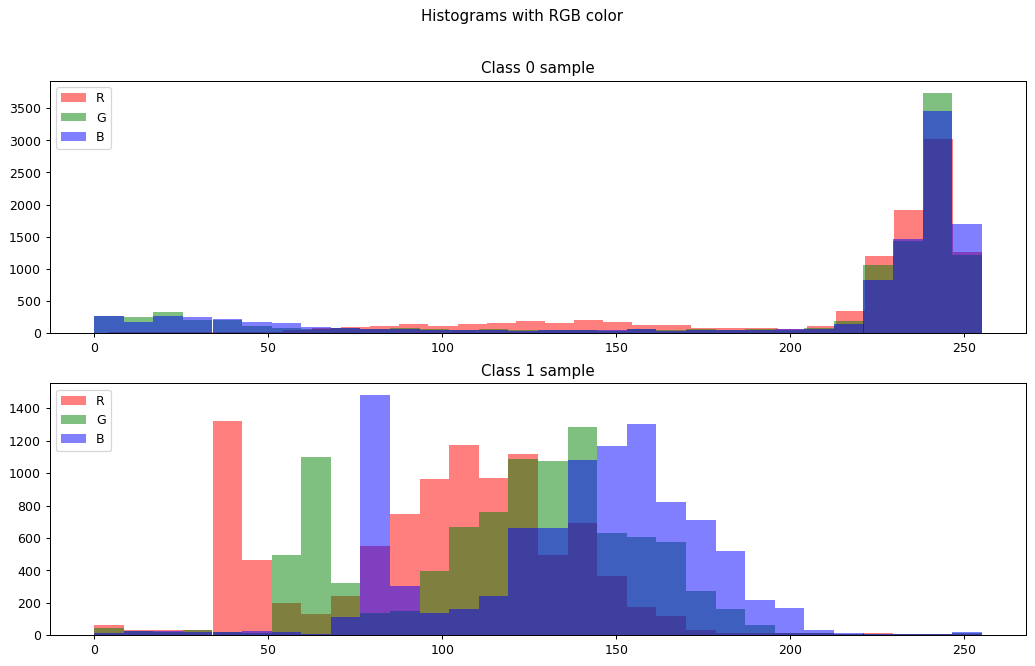

In [14]:
figure, subplots = plt.subplots(2, 1, figsize=(14, 8))
figure.suptitle("Histograms with RGB color")

x = 0
for sample in samples:
    subplots[x].hist(sample['red'].flatten(), bins=30, alpha=0.5, label="R", color="red")
    subplots[x].hist(sample['green'].flatten(), bins=30, alpha=0.5, label="G", color="green")
    subplots[x].hist(sample['blue'].flatten(), bins=30, alpha=0.5, label="B", color="blue")
    subplots[x].legend(loc='upper left')
    subplots[x].title.set_text(f"Class {sample['label']} sample")
    print(f"Class {sample['label']} sample")
    print(f"Red\tMean:{round(sample['red'].flatten().mean(),2)}\tMedian:{np.median(sample['red'].flatten())}\tVariance:{round(np.var(sample['red'].flatten()),2)}")
    print(f"Green\tMean:{round(sample['green'].flatten().mean(),2)}\tMedian:{np.median(sample['green'].flatten())}\tVariance:{round(np.var(sample['green'].flatten()),2)}")
    print(f"Blue\tMean:{round(sample['blue'].flatten().mean(),2)}\tMedian:{np.median(sample['blue'].flatten())}\tVariance:{round(np.var(sample['blue'].flatten()),2)}")
    x += 1

plt.show()

* However, many of these pictures are invalid (meaningless) pictures because they are simply logos (below is an example). We need to remove these grey-ish pictures. The way to do it is to throw away images that have very low variance.

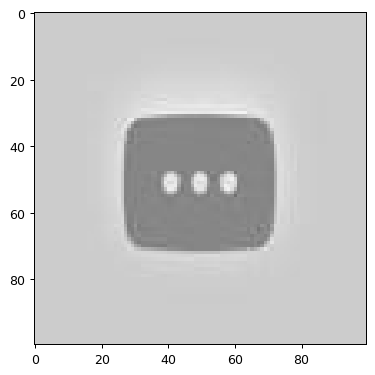

In [15]:
plt.imshow(images['0img_0034.jpeg'])

## D2.3: Data Wrangling

* At this point, we want to remove all images that look extremely grey.

In [16]:
df['rvar'] = np.array(np.var(x.flatten()) for x in df['red'])
df['gvar'] = np.array(np.var(x.flatten()) for x in df['green'])
df['bvar'] = np.array(np.var(x.flatten()) for x in df['blue'])
df = df[df['rvar']+df['gvar']+df['bvar'] > 200]

In [17]:
df.shape,df.columns

((805, 9),
 Index(['ID', 'image', 'label', 'red', 'green', 'blue', 'rvar', 'gvar', 'bvar'], dtype='object'))

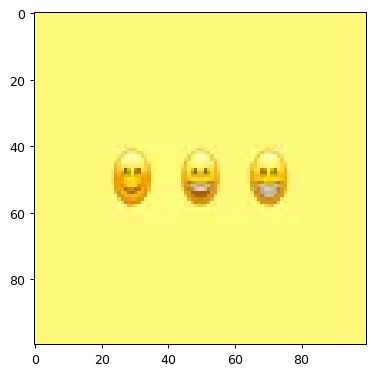

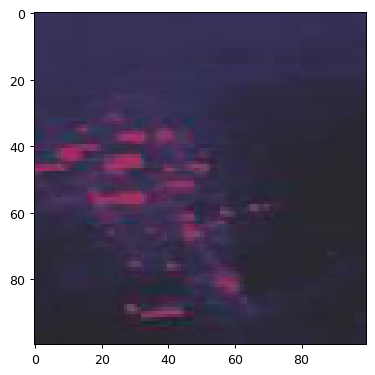

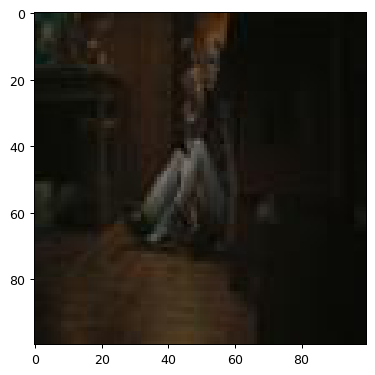

In [18]:
for i in ['rvar','gvar','bvar']:
    plt.imshow(np.array(df[df[i] == df[i].min()]['image'].values[0]).reshape(100,100,3))
    plt.show()

* We can see that even pictures with smallest variances are not logos! Our data is clean (I can't think of a way to prove this, but I think it works)!

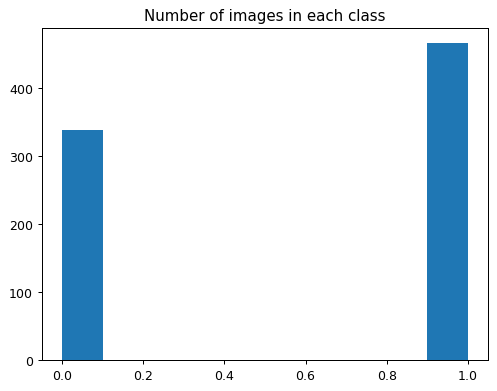

In [19]:
plt.hist(df['label'])
plt.title("Number of images in each class")
plt.show()

* Now the pictures and the color distributions make much more sense.

## D2.4: Feature Engineering

* We take the means of colors as features

In [20]:
df['rmean'] = np.array(np.mean(x.flatten()) for x in df['red'])
df['gmean'] = np.array(np.mean(x.flatten()) for x in df['green'])
df['bmean'] = np.array(np.mean(x.flatten()) for x in df['blue'])

* As well as skewness and kurtosis of colors

In [21]:
from scipy.stats import skew, kurtosis

df['rskew'] = np.array(skew(x.flatten()) for x in df['red'])
df['gskew'] = np.array(skew(x.flatten()) for x in df['green'])
df['bskew'] = np.array(skew(x.flatten()) for x in df['blue'])

df['rkurt'] = np.array(kurtosis(x.flatten()) for x in df['red'])
df['gkurt'] = np.array(kurtosis(x.flatten()) for x in df['green'])
df['bkurt'] = np.array(kurtosis(x.flatten()) for x in df['blue'])

* It would also be interesting to use a more powerful feature, HOG

In [22]:
from skimage.feature import hog
from skimage.color import rgb2gray
from skimage.transform import resize

def get_hog(img):
    grey = resize(rgb2gray(img),(100,100))
    fd, hog_image = hog(grey, orientations=8, pixels_per_cell=(8, 8), 
                    cells_per_block=(2, 2), visualize=True)
    return hog_image

df['HOG'] = np.array(get_hog(x) for x in df['image'])

In [23]:
# finding some samples of each class
samples = []

curtar = 0 # we're finding this example now
for index, row in df.iterrows():
    if row['label'] == curtar:
        samples.append(row)
        curtar += 1
    if curtar > 3: # when we found all classes
        break

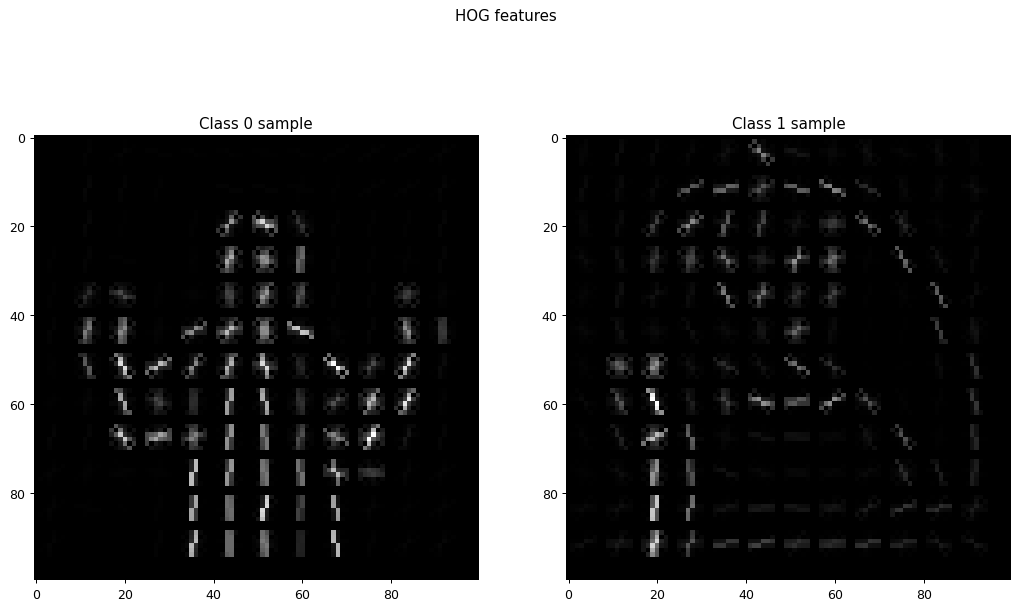

In [24]:
# RGB plots
figure, subplots = plt.subplots(1, 2, figsize=(14, 8))
figure.suptitle("HOG features")

x = 0
for sample in samples:
    subplots[x].imshow(np.array(sample['HOG']),cmap='gray')
    subplots[x].title.set_text(f"Class {sample['label']} sample")
    x += 1
plt.show()

In [25]:
df = df.reset_index()

In [26]:
df = df[['ID','image','red','green','blue','rvar','gvar','bvar','rmean','gmean','bmean','rskew','gskew','bskew','rkurt','gkurt','bkurt','HOG','label']]

In [27]:
df = df.infer_objects()

In [28]:
df.describe()

,rvar,gvar,bvar,rmean,gmean,bmean,rskew,gskew,bskew,rkurt,gkurt,bkurt,label
count,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000
mean,3293.491567,3156.950912,3168.347098,141.144818,131.291647,126.617448,-0.393236,-0.201958,-0.075074,2.589737,1.934698,2.002027,0.578882
std,2253.336130,2119.525919,2276.227216,60.932549,57.606728,59.080350,1.727060,1.563508,1.579359,12.079658,8.018725,8.464084,0.494045
min,66.050702,28.810138,150.529538,2.259200,2.140400,2.113700,-15.113786,-7.065387,-7.602981,-1.882685,-1.857187,-1.854455,0.000000
25%,1404.759948,1435.248414,1191.851130,93.526300,85.765900,75.293300,-1.490204,-1.184241,-1.076055,-0.837022,-0.919636,-0.965678,0.000000
50%,2997.110598,2868.731651,2766.719624,143.041700,130.375100,126.216400,-0.309555,-0.159877,-0.045936,0.086766,-0.087917,0.016520,1.000000
75%,4632.179807,4502.592277,4604.368343,193.947200,180.668000,179.171400,0.606225,0.726702,0.836205,1.843905,1.347460,1.372263,1.000000
max,10673.559773,11886.632710,13145.662440,252.704200,250.246800,250.592200,9.602424,9.694218,9.711602,242.344427,115.192297,115.693500,1.000000


* How good are these features?

C:\Users\20250\AppData\Local\Temp\ipykernel_30136\2387992518.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


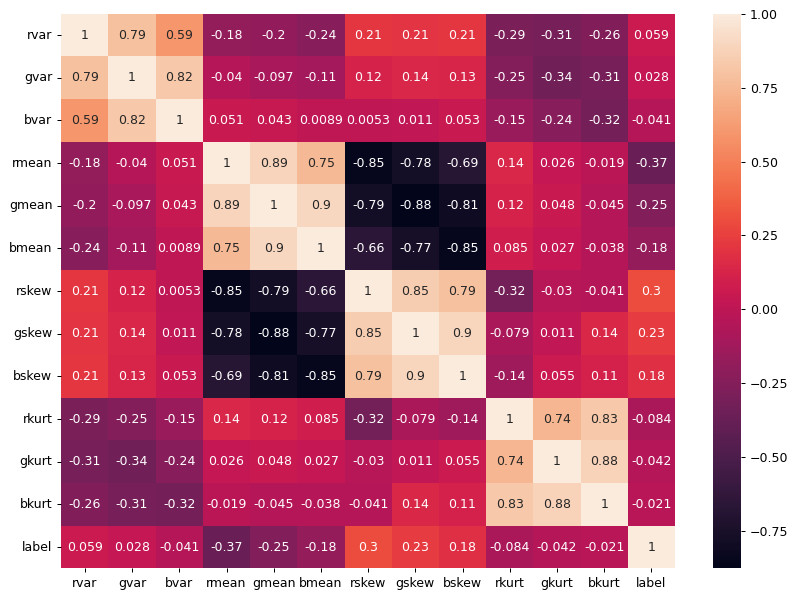

In [29]:
import seaborn as sns
corr = df.corr()
plt.figure(figsize=(11,8))
sns.heatmap(corr, annot=True)
plt.show()

* A interesting observation here: each category of statistical measurement (mean, variance, skewness, kurtosis) is closely correlated with one another. Skewness is negatively correlated with mean. As skewness are more correlated with label, let's lose mean!
* Let's add some polynomial features!

In [30]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)
polyfeatures = poly.fit_transform(df[['rvar','gvar','bvar','rskew','gskew','bskew','rkurt','gkurt','bkurt']])
polydf = pd.DataFrame(polyfeatures,columns=poly.get_feature_names_out())
df = pd.concat([df[['ID','image','red','green','blue','rvar','gvar','bvar','rskew','gskew','bskew','rkurt','gkurt','bkurt']],polydf,df[['HOG','label']]],axis=1)

* As the correlation heatmap will be too dense, let's not annotate.

C:\Users\20250\AppData\Local\Temp\ipykernel_30136\834880012.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


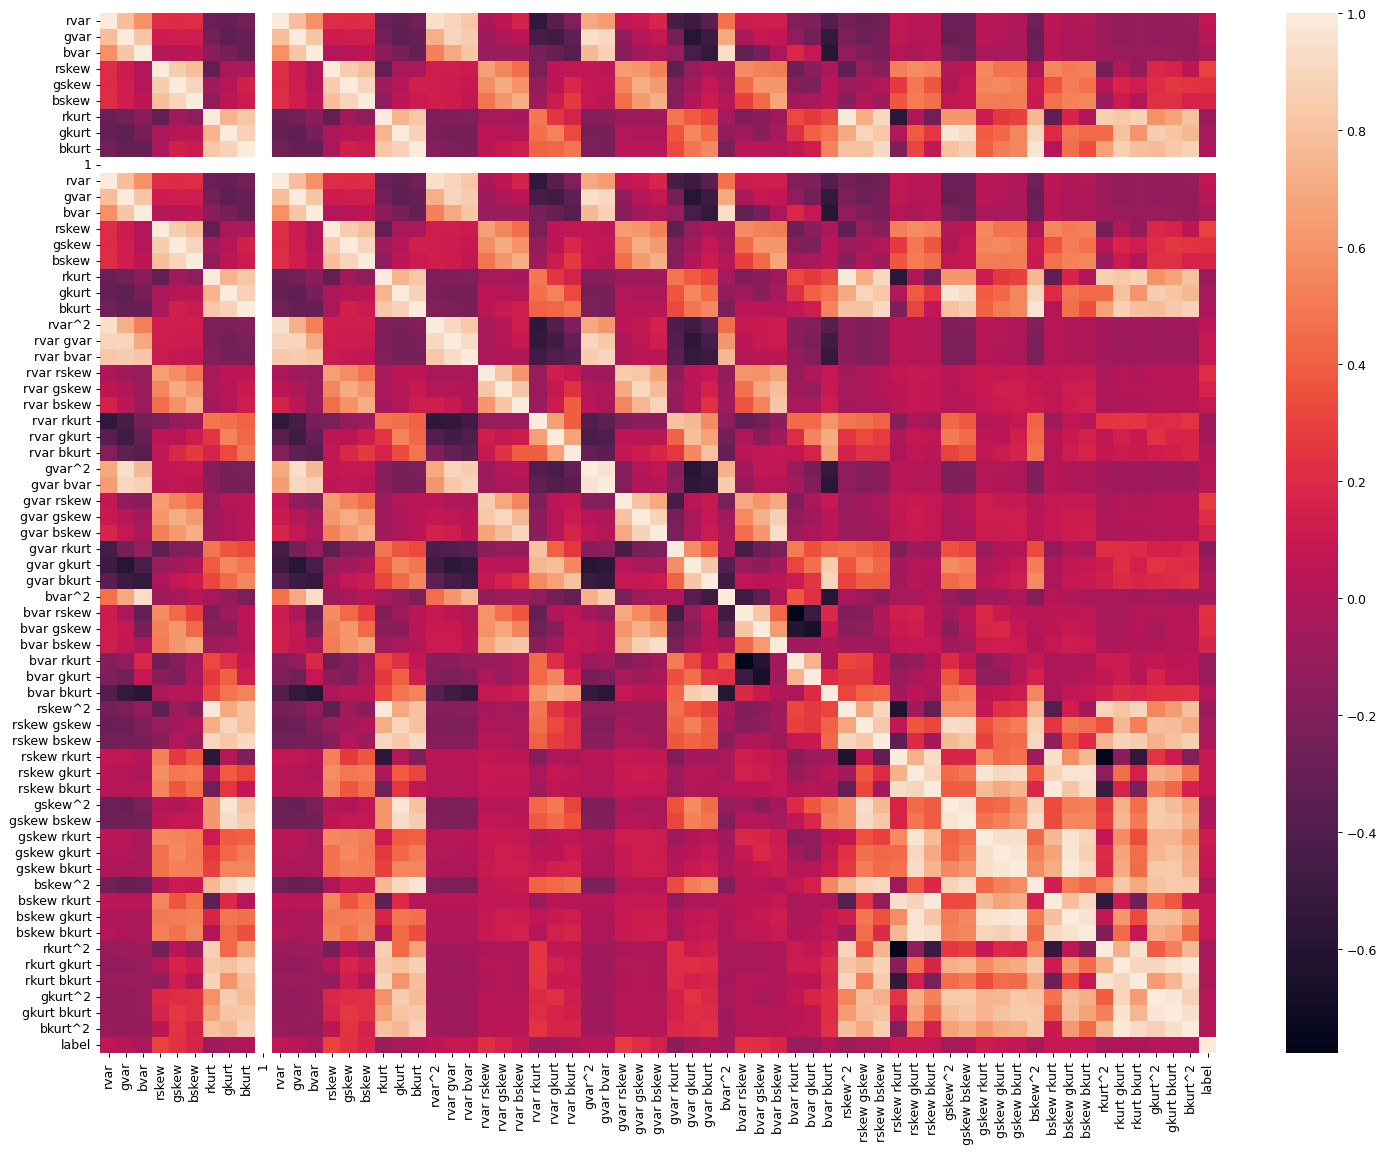

In [31]:
corr = df.corr()
plt.figure(figsize=(20,15))
sns.heatmap(corr)
plt.show()

In [32]:
df.describe()

,rvar,gvar,bvar,rskew,gskew,bskew,rkurt,gkurt,bkurt,1,...,bskew rkurt,bskew gkurt,bskew bkurt,rkurt^2,rkurt gkurt,rkurt bkurt,gkurt^2,gkurt bkurt,bkurt^2,label
count,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000,805.0,...,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000
mean,3293.491567,3156.950912,3168.347098,-0.393236,-0.201958,-0.075074,2.589737,1.934698,2.002027,1.0,...,-2.926783,0.551339,1.269061,152.443599,76.770405,89.766391,67.963137,63.509796,75.559830,0.578882
std,2253.336130,2119.525919,2276.227216,1.727060,1.563508,1.579359,12.079658,8.018725,8.464084,0.0,...,89.262603,61.553627,67.367801,2187.502907,771.528178,1158.847124,690.004460,695.598998,803.252069,0.494045
min,66.050702,28.810138,150.529538,-15.113786,-7.065387,-7.602981,-1.882685,-1.857187,-1.854455,1.0,...,-1842.540095,-343.956122,-844.668838,0.000037,-15.145812,-107.087299,0.000019,-33.748097,0.000019,0.000000
25%,1404.759948,1435.248414,1191.851130,-1.490204,-1.184241,-1.076055,-0.837022,-0.919636,-0.965678,1.0,...,-1.491935,-0.971608,-0.703749,0.439454,0.293205,0.094948,0.419822,0.274093,0.458208,0.000000
50%,2997.110598,2868.731651,2766.719624,-0.309555,-0.159877,-0.045936,0.086766,-0.087917,0.016520,1.0,...,-0.216237,-0.123993,-0.041326,1.166098,1.166098,1.044497,1.166098,1.166098,1.166098,1.000000
75%,4632.179807,4502.592277,4604.368343,0.606225,0.726702,0.836205,1.843905,1.347460,1.372263,1.0,...,0.291017,0.385436,0.490785,3.510006,2.507395,2.138822,2.632874,2.422403,2.677602,1.000000
max,10673.559773,11886.632710,13145.662440,9.602424,9.694218,9.711602,242.344427,115.192297,115.693500,1.0,...,1103.703277,1118.701742,1123.569226,58730.821352,13091.363771,26923.753112,13269.265177,13326.999901,13384.985830,1.000000


$\to$ Here we have completed the dataset `df`! However, I might come back and add more features if I find that I needed for for better training.<br>
$\to$ I will also consider adding different orientations of images to make my dataset larger